In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import load_iris


# Load the dataset
file_path = '../dataset/heart.csv'  # replace with your actual file path
data = pd.read_csv(file_path)

# Define the feature columns and the target column
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

target = 'target'

if target in features:
    features.remove(target)




In [20]:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

print("Feature columns:", features)
print("Target column:", target)

# Split the data into training and testing sets
print("Splitting the dataset into training and testing sets...")
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Initialize and train the Decision Tree classifier
print("Training the Decision Tree classifier...")
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
print("Model training complete.")



Feature columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Target column: target
Splitting the dataset into training and testing sets...
Training set size: 820 samples
Testing set size: 205 samples
Training the Decision Tree classifier...
Model training complete.


Making predictions on the training set...
Evaluating the model on the training set...
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       397
           1       1.00      1.00      1.00       423

    accuracy                           1.00       820
   macro avg       1.00      1.00      1.00       820
weighted avg       1.00      1.00      1.00       820

Making predictions on the test set...
Predictions complete. Here are the first 5 predictions:
[1 1 0 1 0]
Evaluating the model on the test set...
Test Accuracy: 0.99
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

Performing

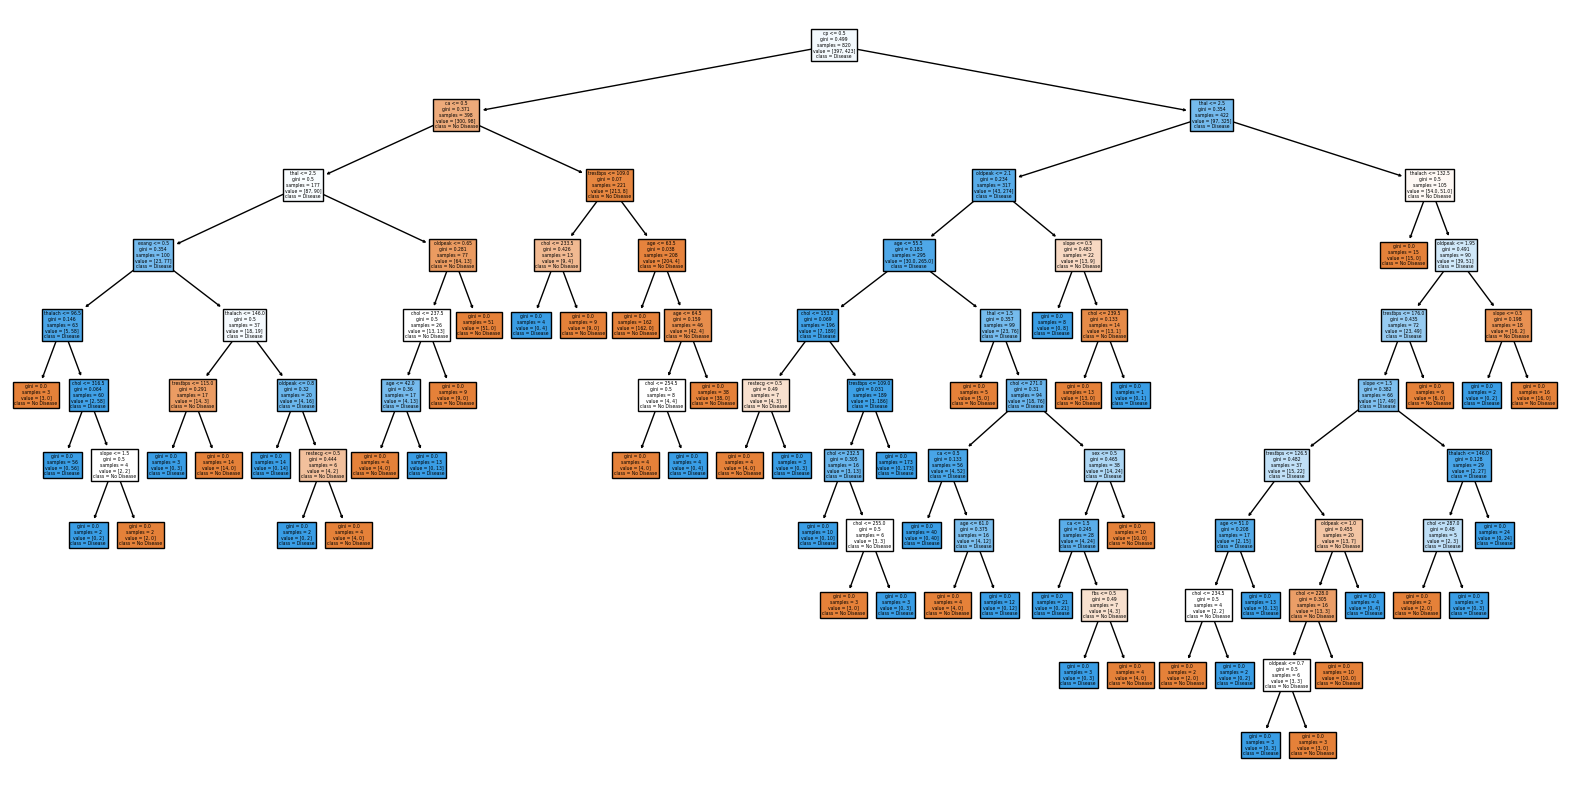

In [21]:
# Make predictions on the training set
print("Making predictions on the training set...")
y_train_pred = clf.predict(X_train)

# Evaluate the model on the training set
print("Evaluating the model on the training set...")
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print("Training Classification Report:")
print(train_report)

# Make predictions on the test set
print("Making predictions on the test set...")
y_pred = clf.predict(X_test)
print("Predictions complete. Here are the first 5 predictions:")
print(y_pred[:5])

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print("Test Classification Report:")
print(test_report)


# Perform cross-validation
print("Performing cross-validation...")
cv_scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")


# Check for overfitting
if train_accuracy > test_accuracy:
    print("The model may be overfitting. Consider tuning hyperparameters or pruning the tree.")

# Visualize the Decision Tree
print("Visualizing the Decision Tree...")
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=features, class_names=["No Disease", "Disease"])
plt.show()

jtune the hyper params

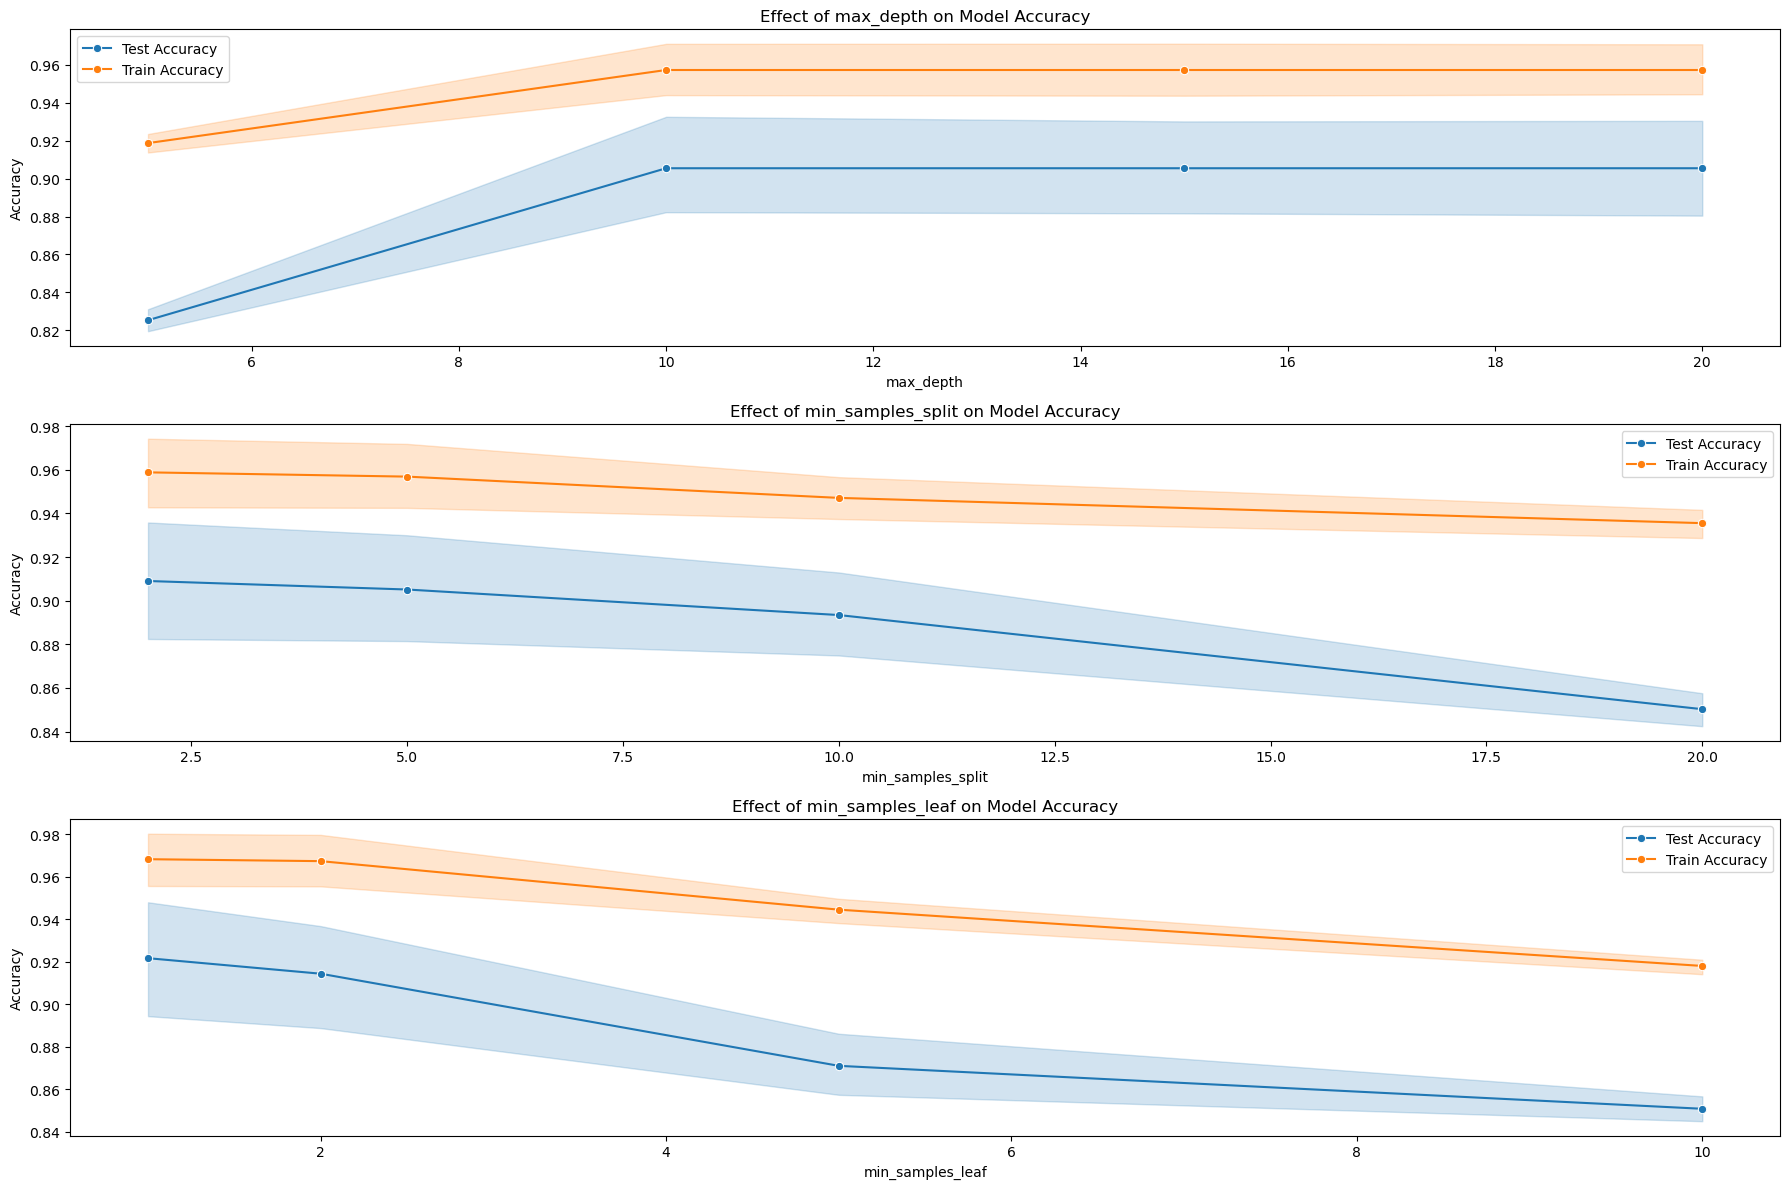

In [22]:
import seaborn as sns
# Function to train and evaluate the model with given hyperparameters
def evaluate_model(max_depth=None, min_samples_split=2, min_samples_leaf=1):
    clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    return train_accuracy, test_accuracy

# Define the parameter ranges
max_depth_range = [None, 5, 10, 15, 20]
min_samples_split_range = [2, 5, 10, 20]
min_samples_leaf_range = [1, 2, 5, 10]

# Initialize lists to store the results
results = {
    'max_depth': [],
    'min_samples_split': [],
    'min_samples_leaf': [],
    'train_accuracy': [],
    'test_accuracy': []
}

# Evaluate the model for each combination of parameters
for max_depth in max_depth_range:
    for min_samples_split in min_samples_split_range:
        for min_samples_leaf in min_samples_leaf_range:
            train_acc, test_acc = evaluate_model(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            results['max_depth'].append(max_depth)
            results['min_samples_split'].append(min_samples_split)
            results['min_samples_leaf'].append(min_samples_leaf)
            results['train_accuracy'].append(train_acc)
            results['test_accuracy'].append(test_acc)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting the results
plt.figure(figsize=(18, 12))

# Plot for max_depth
plt.subplot(3, 1, 1)
sns.lineplot(x='max_depth', y='test_accuracy', data=results_df, marker='o', label='Test Accuracy')
sns.lineplot(x='max_depth', y='train_accuracy', data=results_df, marker='o', label='Train Accuracy')
plt.title('Effect of max_depth on Model Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

# Plot for min_samples_split
plt.subplot(3, 1, 2)
sns.lineplot(x='min_samples_split', y='test_accuracy', data=results_df, marker='o', label='Test Accuracy')
sns.lineplot(x='min_samples_split', y='train_accuracy', data=results_df, marker='o', label='Train Accuracy')
plt.title('Effect of min_samples_split on Model Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.legend()

# Plot for min_samples_leaf
plt.subplot(3, 1, 3)
sns.lineplot(x='min_samples_leaf', y='test_accuracy', data=results_df, marker='o', label='Test Accuracy')
sns.lineplot(x='min_samples_leaf', y='train_accuracy', data=results_df, marker='o', label='Train Accuracy')
plt.title('Effect of min_samples_leaf on Model Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()